## Семинар 4: "Сверточные сети"

ФИО: Новикова Анастасия

In [14]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline
import sys

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [15]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ker, sig  = len(kernel), len(signal)
    kernel = kernel[::-1]
    ks = sig - ker + 1
    for i in range(0, ks):
        temp_sum =0
        for j in range(0, ker):
                temp_sum += signal[i+j] * kernel[j]
        signal_convolved[i] = temp_sum
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [16]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

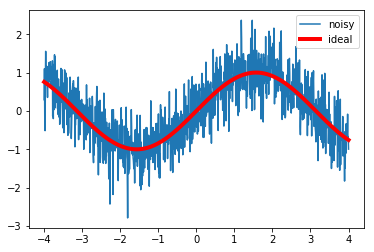

In [17]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [18]:
kernel = [0.2,0.2,0.2,0.2,0.2]

denoised_signal = t_convolve(signal, kernel)

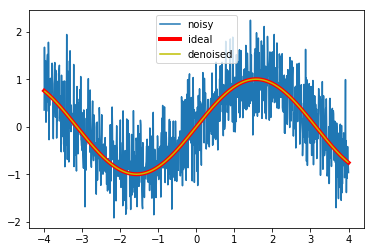

In [19]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [123]:
#kernel = [0.2,0.2,0.2,0.2,0.2] OK

In [20]:
errors = []

def get_plot(kernel):
    x = np.linspace(-4, 4, 1000)
    signal = np.sin(x)
    noisy_signal = signal + np.random.randn(signal.shape[0])
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)
    denoised_signal = t_convolve(signal, kernel)
    k = len (kernel) / 2
    plt.plot(x[k:-k], denoised_signal, 'y', label='denoised')
    error = np.linalg.norm (signal[k:-k] - denoised_signal)
    errors.append(error)
    plt.xlabel ('Len:{} Er:{}'.format (len(kernel), error))
    plt.legend(loc=0)
    plt.show ()
    return np.argmin(errors)

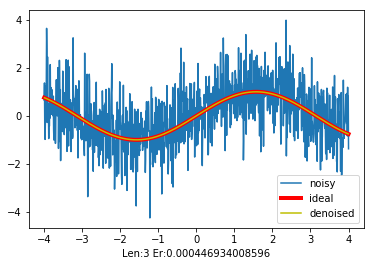

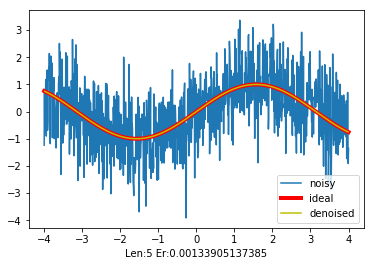

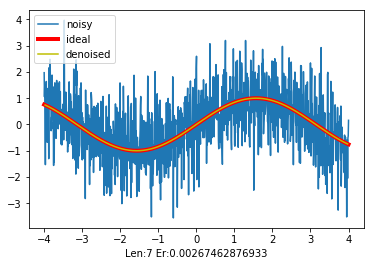

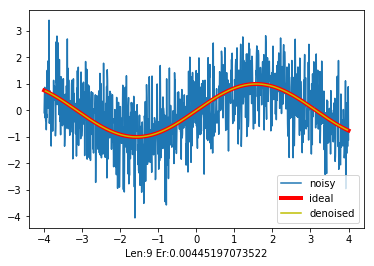

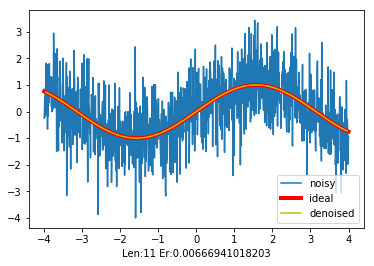

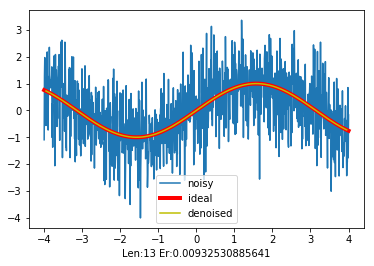

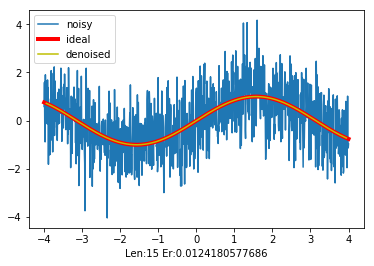

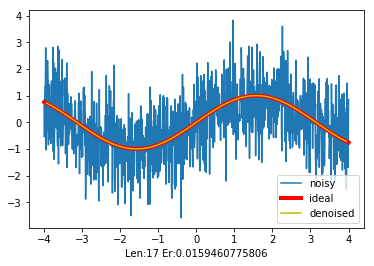

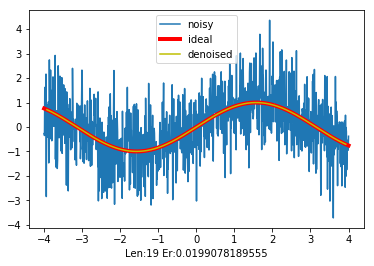

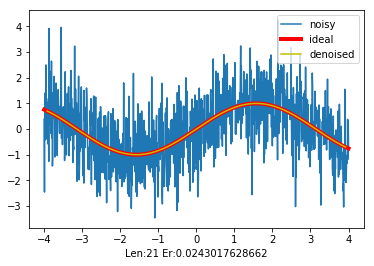

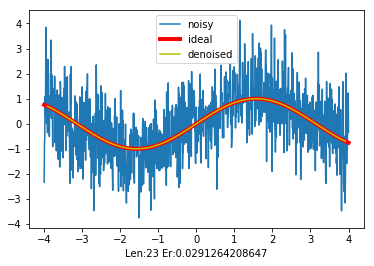

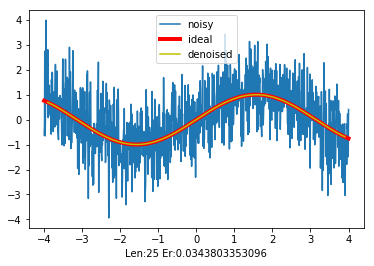

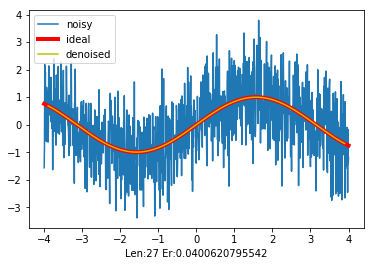

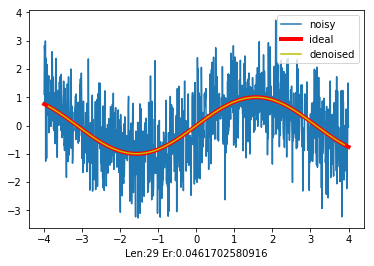

In [21]:
for i in range (3, 30, 2):
    kernel = [1.0 / i] * i
    get_plot(kernel)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [22]:
% cd Desktop/Technosphere/Neuron_networks/

/Users/an.novikova/Desktop/Technosphere/Neuron_networks


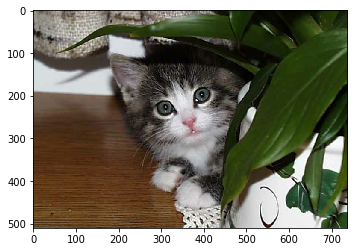

In [51]:
image = plt.imread('my_cat.png')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [36]:
def convert(img, coefs=np.array([0.299, 0.587, 0.114])):
    return np.dot(img[..., :3], coefs)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

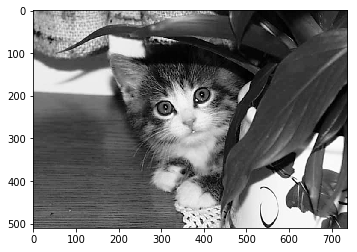

In [52]:
image = plt.imread('my_cat.png')
plt.imshow(image)
plt.imshow(convert(image), cmap=plt.cm.Greys_r)

In [43]:
def cnv_convert(img, kernel = np.array([0.114,0.587,0.299])):
    kernel = kernel.reshape(1,1,-1)
    bw_image = convolve(kernel,image, mode='valid')
    print(bw_image.shape)
    return bw_image.reshape(bw_image.shape[0],bw_image.shape[1])

(510, 737, 1)


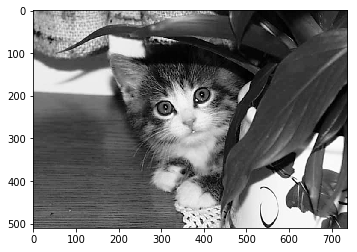

In [53]:
image = plt.imread('my_cat.png')
plt.imshow(image)
plt.imshow(cnv_convert(image), cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [54]:
def sobel_filter(img):
    h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    v = np.transpose(h)

    conv_x = convolve(img, h)
    conv_y = convolve(img, v)

    result = np.sqrt(conv_x ** 2 + conv_y ** 2)

    return result

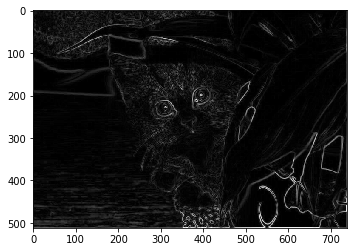

In [55]:
from skimage.color import rgb2gray

img_gray = rgb2gray(image)

bw_image = sobel_filter(img_gray)
plt.imshow(bw_image, cmap="gray")
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [47]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim + 1
    out = np.zeros((signal.shape[0],signal.shape[1], signal.ndim+1))
    out[...,0] = convolve(kernel[0].reshape(1,1,-1), signal, mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,1] = convolve(signal, kernel[1].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,2] = convolve(signal, kernel[2].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,3] = convolve(signal, kernel[3].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    return out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [48]:
bank_filter = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]])

In [49]:
# image = plt.imread('Lenna.png')

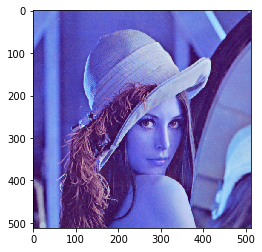

In [50]:
sb_image = sobel_filter(rgb2gray(image))
conv = t_convolve_bank(image, bank_filter)
plt.imshow(conv[...,[0,1,2]])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [175]:
colors = np.array(
      [[-0.5,-1,-0.1],
       [0.1, 0.1, 0.1],
       [1,2,1],
       [0, 0, 0.5]])

In [178]:
image = plt.imread('Lenna.png')
pic = t_convolve_bank(image, colors)

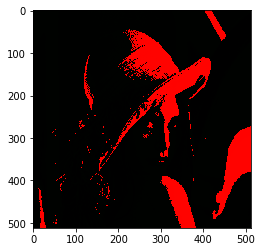

In [179]:
plt.imshow(pic.astype('uint8')[...,[0,2,3]])

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [56]:
from scipy.ndimage.filters import maximum_filter, median_filter, gaussian_filter
import copy

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [57]:
def salt_and_pepper(image):
    x, y, z = image.shape
    return image + np.random.normal(1, 0.1, (x, y, z)).reshape(x, y, z)

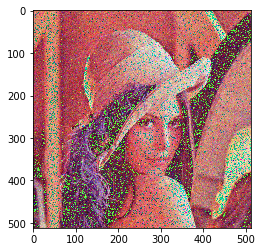

In [63]:
image = plt.imread('Lenna.png')
pic = salt_and_pepper(image)
plt.imshow(pic)

In [64]:
def maxpool(img, window_size):
    assert(img.ndim == 3)
    a = image.shape[0] // 2
    b = image.shape[1] // 2
    m = np.zeros((a, b , 3))
    cp = copy.deepcopy(img)
    
    for n in range(0, img.ndim):
        q = cp[..., n]
        for j in range(0, a):
            for i in range(0, b):
                m[i][j][n] = np.max(q[2*i: 2*i + 2, 2*j: 2*j + 2])
       
    return m

In [65]:
def medianpool(img, window_size):
    assert(img.ndim == 3)
    a = image.shape[0] // 2
    b = image.shape[1] // 2
    m = np.zeros((a, b, 3))

    cp = copy.deepcopy(img)
    for n in range(0, img.ndim):
        q = cp[..., n]
        for j in range(0, a):
            for i in range(0, b):
                m[i][j][n] = np.median(q[2*i: 2*i + 2, 2*j: 2*j + 2])
       
    return m

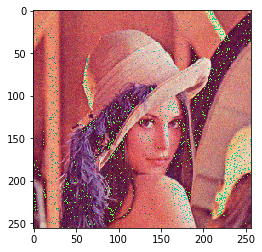

In [66]:
w_size = 2
plt.imshow(medianpool(pic, w_size))

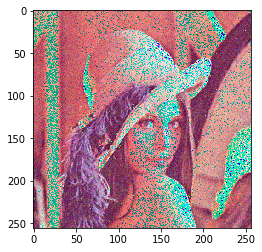

In [67]:
w_size = 4
plt.imshow(maxpool(pic, w_size))

In [ ]:
# The best one is medianpool

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [8]:
# пример сверточной сети

image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*3, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [9]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[:batch_size])
y = Variable(labels_train[:batch_size], requires_grad=False)
output = network.forward(X)

In [10]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print 'Current loss:', loss.data[0]

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 39.6758346558


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [68]:
model = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, ), (0.3081, ))
                    ])
train_data = MNIST('.', train=True, download=True, transform=model)
test_data = MNIST('.', train=False, transform=model)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

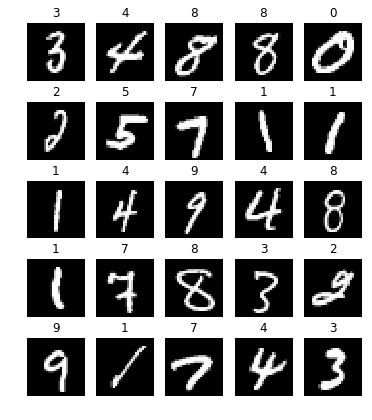

In [69]:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() 
    y = y.numpy()


plt.figure(figsize=(6, 7))

n = 25
k = 5
s = 28
for i in range(n):
    plt.subplot(k, k, i+1)
    plt.imshow(X[i].reshape(s, s), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [70]:
class ConvolutionNetwork(nn.Module):
    
    def __init__(self):
        super(ConvolutionNetwork, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(11 * 11 * 16, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [71]:
class ConvolutionNetworkTwo(nn.Module):
    def __init__(self):
        super(ConvolutionNetworkTwo, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.Conv2d(8, 16, 3), nn.ReLU(),
                                        nn.MaxPool2d(2), nn.Conv2d(16, 32, 3))
        self.linear_layers = nn.Sequential(nn.Linear(32 * 10 * 10, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [72]:
network1 = ConvolutionNetwork()
loss_function1 = torch.nn.NLLLoss()
l_rate = 0.001
optimizer1 = torch.optim.Adam(network1.parameters(), lr=l_rate)

In [73]:
n = 30
for i in range(n):    
    for X, y in train_loader:
        output = network1.forward(Variable(X))
        loss = loss_function1(output, Variable(y, requires_grad=False))
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()              
    sys.stdout.write('\r {} Loss: {}'.format(i, loss.data[0]))

 29 Loss: 0.008311841636997

In [74]:
network2 = ConvolutionNetworkTwo()
loss_function2 = torch.nn.NLLLoss()
l_rate = 0.001
optimizer2 = torch.optim.Adam(network2.parameters(), lr=l_rate)

In [75]:
n = 30
for i in range(n):    
    for X, y in train_loader:
        output = network2.forward(Variable(X))
        loss = loss_function2(output, Variable(y, requires_grad=False))
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()        
    sys.stdout.write('\r {} Loss: {}'.format(i, loss.data[0]))

 29 Loss: 3.72781300939e-06

In [ ]:
# mistakes

In [77]:
predicted_losses = np.zeros(len(train_data))
predicted_cls = np.zeros(len(train_data))

In [80]:
for i in range(len(train_data)):
        X, y = train_data[i]
        output = network1.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        loss = loss_function1(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()

In [81]:
predicted_args = predicted_losses.argsort()[-25:]
predicted_cls = predicted_cls[predicted_args]

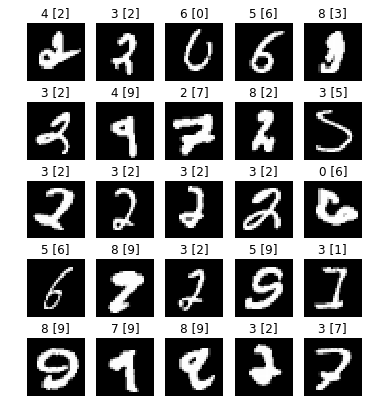

In [83]:
plt.figure(figsize=(6, 7))
for i in range(len(predicted_args)):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_data[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    real = str(train_data[predicted_args[i]][1])
    plt.title(str(int(predicted_cls[i])) + ' [' + real + ']')
    plt.axis('off')

In [ ]:
# The second model

In [84]:
predicted_losses = np.zeros(len(train_data))
predicted_cls = np.zeros(len(train_data))

In [86]:
for i in range(len(train_data)):
        X, y = train_data[i]
        output = network2.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        loss = loss_function2(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()

In [87]:
predicted_args = predicted_losses.argsort()[-25:]
predicted_cls = predicted_cls[predicted_args]

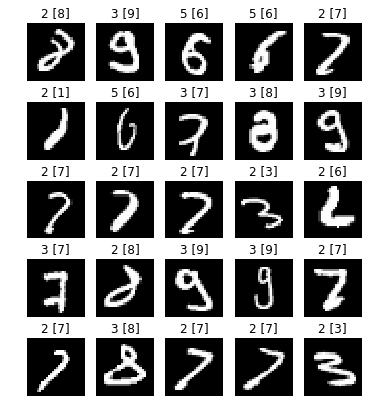

In [90]:
plt.figure(figsize=(6, 7))
for i in range(len(predicted_args)):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_data[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    real = str(train_data[predicted_args[i]][1])
    plt.title(str(int(predicted_cls[i])) + ' [' + real + ']')
    plt.axis('off')

In [91]:
predicted_cls = np.array([])
real_cls = np.array([])
for X, y in test_loader:
        output = network1.forward(Variable(X))        
        predicted_cls = np.append(predicted_cls, output.data.numpy().argmax(axis=1))
        real_cls = np.append(real_cls, y.numpy())

In [92]:
from sklearn.metrics import accuracy_score, f1_score

In [93]:
print '{} {}'.format('f1_score is: ', f1_score(real_cls, predicted_cls, average='micro'))
print '{} {}'.format('accuracy_score is: ', accuracy_score(real_cls, predicted_cls))

f1_score is:  0.9853
accuracy_score is:  0.9853
